# **Task 1: Discriminative Models – CNN vs. ViT Inductive Biases**

**Loading the dataset**

In [1]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Define your transforms (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 for ViT
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download the train split
trainset = torchvision.datasets.STL10(
    root='./data',           # where to store it
    split='train',           # 'train' or 'test' or 'unlabeled'
    download=True,           # actually download from the internet
    transform=transform
)

# Download the test split
testset = torchvision.datasets.STL10(
    root='./data',
    split='test',
    download=True,
    transform=transform
)

# Make DataLoaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

print("Training samples:", len(trainset))
print("Test samples:", len(testset))

100%|██████████| 2.64G/2.64G [00:29<00:00, 88.1MB/s]


Training samples: 5000
Test samples: 8000


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


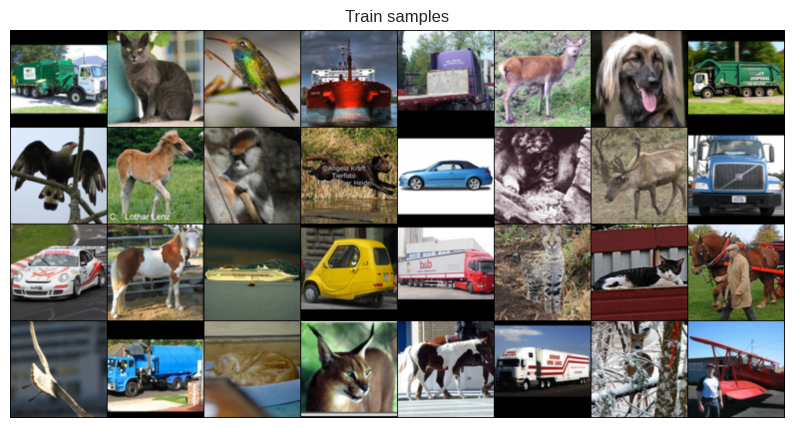

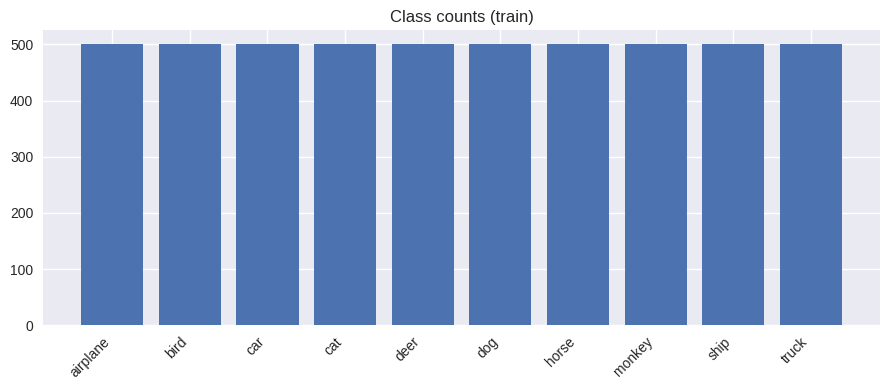

In [3]:
# Preview a grid of training images + class distribution
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

plt.style.use("seaborn-v0_8")

# STL10 class names
stl10_classes = ['airplane','bird','car','cat','deer','dog','horse','monkey','ship','truck']

# Create a small grid
imgs, labs = next(iter(trainloader))
grid = make_grid(imgs[:32], nrow=8, normalize=True, value_range=(-1,1))
plt.figure(figsize=(10,6))
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
plt.axis('off'); plt.title("Train samples"); plt.show()

# Class distribution in train split
counts = np.zeros(10, dtype=int)
for _, y in trainset:
    counts[int(y)] += 1

plt.figure(figsize=(9,4))
plt.bar(range(10), counts)
plt.xticks(range(10), stl10_classes, rotation=45, ha='right')
plt.title("Class counts (train)"); plt.tight_layout(); plt.show()

**Finetuning the models**

In [4]:
# ResNet-50
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = resnet.to(device)

# ViT-B/16 (smallest ViT variant in torchvision)
vit = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
vit.heads.head = nn.Linear(vit.heads.head.in_features, 10)
vit = vit.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:02<00:00, 131MB/s]



Training ResNet-50 (for curves):
Epoch 1: train_acc=0.881, val_acc=0.920
Epoch 2: train_acc=0.968, val_acc=0.934
Epoch 3: train_acc=0.986, val_acc=0.953
Epoch 4: train_acc=0.984, val_acc=0.944
Epoch 5: train_acc=0.984, val_acc=0.947

Training ViT-B/16 (for curves):
Epoch 1: train_acc=0.858, val_acc=0.851
Epoch 2: train_acc=0.920, val_acc=0.900
Epoch 3: train_acc=0.956, val_acc=0.839
Epoch 4: train_acc=0.960, val_acc=0.894
Epoch 5: train_acc=0.958, val_acc=0.818


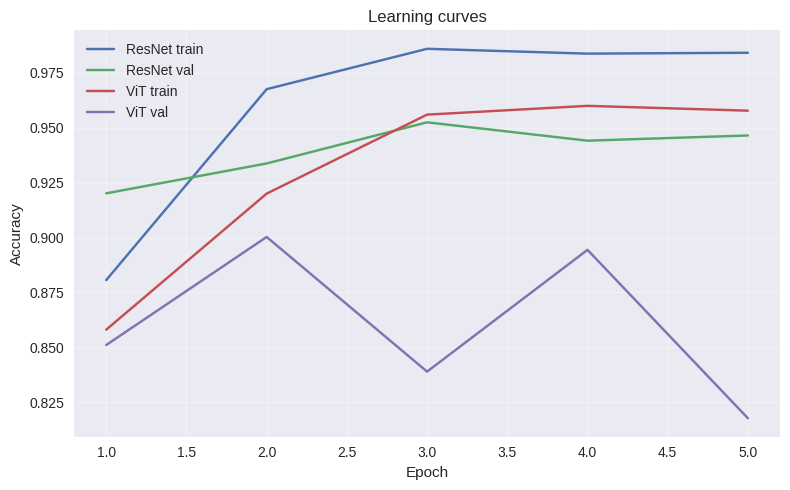

In [5]:
# ------------------ Training / Eval helpers ------------------
def train_model(model, trainloader, testloader, epochs=5, lr=3e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_accs, val_accs = [], []
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            _, pred = out.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)
        train_acc = correct / total
        # Validation
        val_acc = evaluate(model, testloader)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1}: train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")
    return train_accs, val_accs

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, pred = out.max(1)
            correct += pred.eq(y).sum().item()
            total += y.size(0)
    return correct / total

# Training both models
print("\nTraining ResNet-50 (for curves):")
res_train_acc, res_val_acc = train_model(resnet, trainloader, testloader, epochs=5)

print("\nTraining ViT-B/16 (for curves):")
vit_train_acc, vit_val_acc = train_model(vit, trainloader, testloader, epochs=5)

# Plotting curves
epochs = range(1, len(res_train_acc)+1)
plt.figure(figsize=(8,5))
plt.plot(epochs, res_train_acc, label="ResNet train")
plt.plot(epochs, res_val_acc,   label="ResNet val")
plt.plot(epochs, vit_train_acc, label="ViT train")
plt.plot(epochs, vit_val_acc,   label="ViT val")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Learning curves")
plt.legend(); plt.grid(True, alpha=.3); plt.tight_layout(); plt.show()

**In-Distribution Performance**

Clean test — ResNet: 0.947 | ViT: 0.818


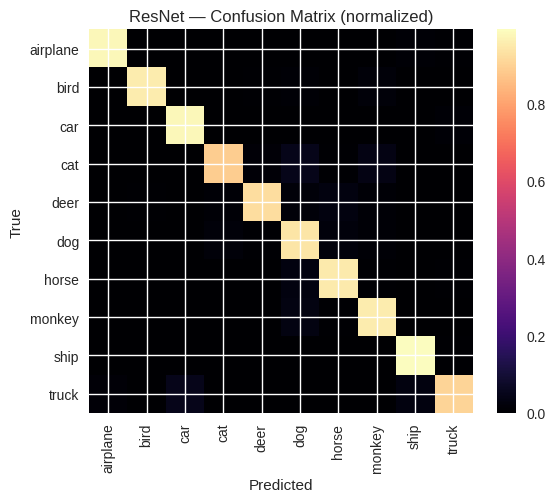

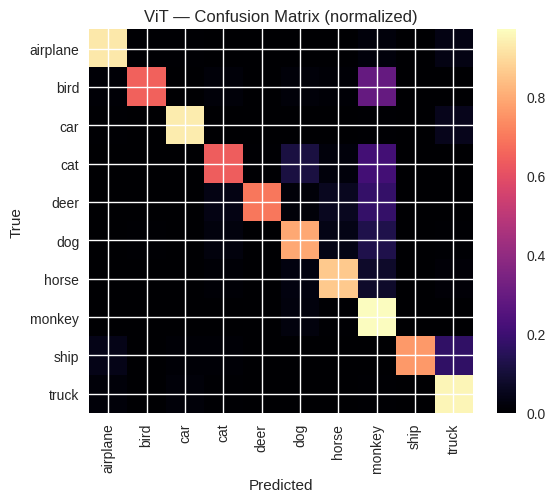

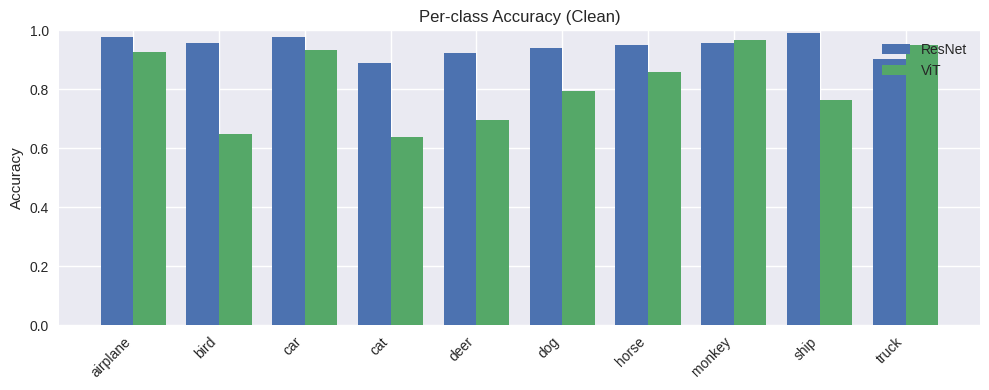

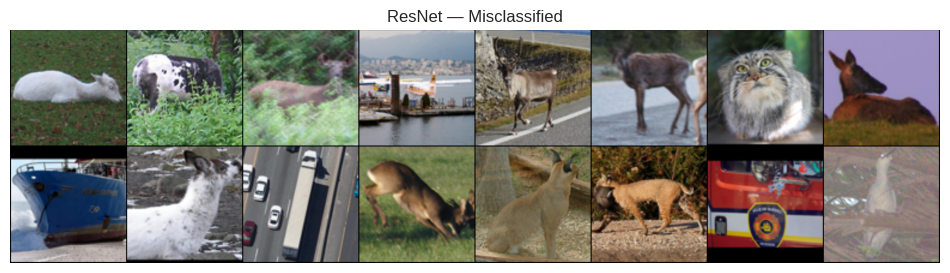

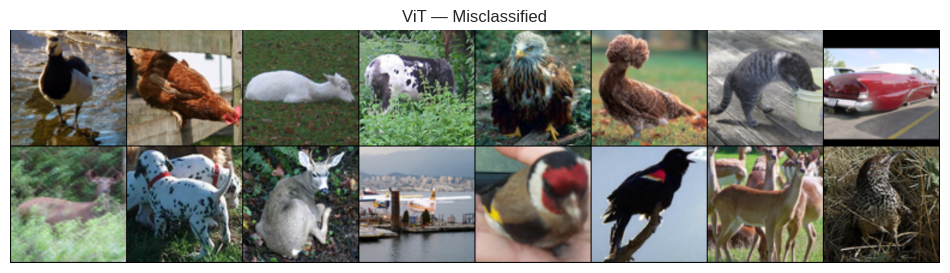

In [6]:
# Baseline accuracy
resnet_clean = evaluate(resnet, testloader)
vit_clean    = evaluate(vit,    testloader)
print(f"Clean test — ResNet: {resnet_clean:.3f} | ViT: {vit_clean:.3f}")

# Confusion matrices + per-class bars
@torch.no_grad()
def get_preds(model, loader):
    model.eval()
    ys, ps = [], []
    for x, y in loader:
        out = model(x.to(device)).cpu()
        ys.append(y); ps.append(out.argmax(1))
    return torch.cat(ys), torch.cat(ps)

def confusion_matrix(y_true, y_pred, n_cls):
    cm = torch.zeros(n_cls, n_cls, dtype=torch.int64)
    for t, p in zip(y_true, y_pred):
        cm[t.long(), p.long()] += 1
    return cm

y_true, y_res = get_preds(resnet, testloader)
_,        y_v = get_preds(vit,    testloader)
n_cls = len(getattr(testset, "classes", list(range(10))))
class_names = list(getattr(testset, "classes", [str(i) for i in range(10)]))

cm_r = confusion_matrix(y_true, y_res, n_cls)
cm_v = confusion_matrix(y_true, y_v,   n_cls)

def plot_cm(cm, title):
    cmn = cm.float() / cm.sum(dim=1, keepdim=True).clamp(min=1)
    plt.figure(figsize=(6,5))
    plt.imshow(cmn.numpy(), cmap="magma")
    plt.colorbar(); plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(n_cls), class_names, rotation=90)
    plt.yticks(range(n_cls), class_names)
    plt.tight_layout(); plt.show()

plot_cm(cm_r, "ResNet — Confusion Matrix (normalized)")
plot_cm(cm_v, "ViT — Confusion Matrix (normalized)")

def per_class_acc(cm):
    return (cm.diag().float() / cm.sum(dim=1).clamp(min=1).float()).numpy()

acc_r = per_class_acc(cm_r); acc_v = per_class_acc(cm_v)
x = np.arange(n_cls); w = 0.38
plt.figure(figsize=(max(8, n_cls),4))
plt.bar(x-w/2, acc_r, width=w, label="ResNet")
plt.bar(x+w/2, acc_v, width=w, label="ViT")
plt.xticks(x, class_names, rotation=45, ha="right")
plt.ylim(0,1); plt.ylabel("Accuracy"); plt.title("Per-class Accuracy (Clean)")
plt.legend(); plt.tight_layout(); plt.show()

# Qualitative: top misclassifications grid
from torchvision.utils import make_grid
def show_misclassified(model, loader, k=16, title="Misclassified"):
    model.eval(); imgs_all=[]
    labels=[]
    with torch.no_grad():
        for x, y in loader:
            p = model(x.to(device)).argmax(1).cpu()
            mask = p != y
            if mask.any():
                xs = x[mask][:k-len(labels)]
                ys = y[mask][:k-len(labels)]
                ps = p[mask][:k-len(labels)]
                labels += [f"T:{class_names[int(yt)]} | P:{class_names[int(pt)]}" for yt, pt in zip(ys, ps)]
                imgs_all.append(xs)
                if len(labels) >= k: break
    if labels:
        imgs = torch.cat(imgs_all, 0)[:k]
        grid = make_grid(imgs, nrow=8, normalize=True, value_range=(-1,1))
        plt.figure(figsize=(12,6))
        plt.imshow(np.transpose(grid.numpy(), (1,2,0))); plt.axis("off")
        plt.title(title); plt.show()

show_misclassified(resnet, testloader, title="ResNet — Misclassified")
show_misclassified(vit,    testloader, title="ViT — Misclassified")

**Color Bias Test**

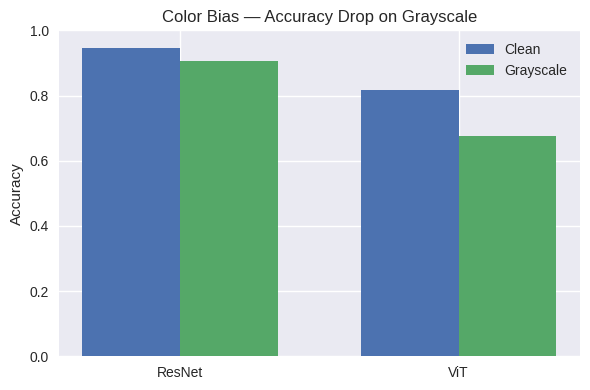

In [7]:
# Build grayscale test loader
gray_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
gray_test   = datasets.STL10(root='./data', split='test', download=True, transform=gray_transform)
grayloader  = DataLoader(gray_test, batch_size=64, shuffle=False, num_workers=2)

resnet_gray = evaluate(resnet, grayloader)
vit_gray    = evaluate(vit,    grayloader)

labels = ["ResNet","ViT"]
clean  = [resnet_clean, vit_clean]
gray   = [resnet_gray,  vit_gray]

x = np.arange(2); w = 0.35
plt.figure(figsize=(6,4))
plt.bar(x-w/2, clean, width=w, label="Clean")
plt.bar(x+w/2, gray,  width=w, label="Grayscale")
plt.xticks(x, labels); plt.ylim(0,1); plt.ylabel("Accuracy")
plt.title("Color Bias — Accuracy Drop on Grayscale")
plt.legend(); plt.tight_layout(); plt.show()

**Shape vs. Texture Bias - Stylized Images**

ResNet — shape-bias% (on shape|texture subset): 85.0% | counts: shape=289, texture=51, other=260, total=600
ViT    — shape-bias% (on shape|texture subset): 77.8% | counts: shape=221, texture=63, other=316,  total=600


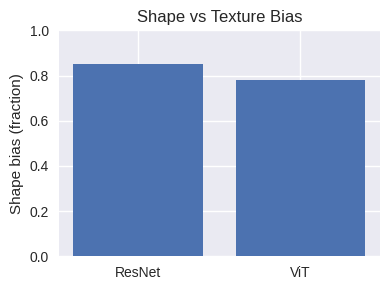

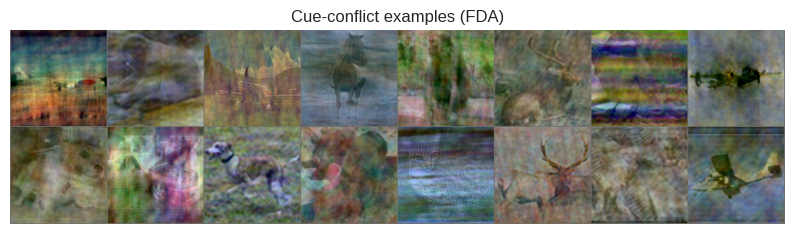

In [8]:
# SIMPLE FDA cue-conflict for STL-10
import numpy as np, random, torch, matplotlib.pyplot as plt
from torch.utils.data import Subset

# Normalization
MEAN = np.array([0.4467, 0.4398, 0.4066], dtype=np.float32)
STD  = np.array([0.2603, 0.2566, 0.2713], dtype=np.float32)

# FDA
def fda_source_to_target(src, trg, beta=None):
    # src,trg: HxWxC in [0,1]
    if beta is None:
        beta = float(np.random.uniform(0.08, 0.15)) # Stronger than 0.02
    src_fft = np.fft.fft2(src, axes=(0,1))
    trg_fft = np.fft.fft2(trg, axes=(0,1))
    src_amp, src_pha = np.abs(src_fft), np.angle(src_fft)
    trg_amp = np.abs(trg_fft)

    h,w,_ = src.shape
    ch,cw = h//2, w//2
    b = int(np.floor(min(h,w)*beta))

    sa = np.fft.fftshift(src_amp, axes=(0,1))
    ta = np.fft.fftshift(trg_amp, axes=(0,1))
    sa[ch-b:ch+b, cw-b:cw+b, :] = ta[ch-b:ch+b, cw-b:cw+b, :]
    sa = np.fft.ifftshift(sa, axes=(0,1))

    styl = np.fft.ifft2(sa * np.exp(1j*src_pha), axes=(0,1)).real
    return np.clip(styl, 0, 1).astype(np.float32)

# Helpers for normalization
def denorm_to_np(t):  # Tensor(C,H,W) normalized -> np(H,W,C) in [0,1]
    x = t.detach().cpu().numpy().transpose(1,2,0)
    x = x * STD + MEAN
    return np.clip(x, 0, 1).astype(np.float32)

def np_to_norm_t(x_np):  # np(H,W,C) in [0,1] -> normalized tensor(C,H,W)
    x = (x_np - MEAN) / STD
    return torch.from_numpy(x.transpose(2,0,1)).float()

# Building cue-conflict set (exact same pattern as yours, but stronger FDA)
subset_idx = list(range(0, min(2000, len(testset))))
sub = Subset(testset, subset_idx)

by_cls = {}
for i in range(len(sub)):
    _, y = sub[i]
    by_cls.setdefault(int(y), []).append(i)
classes = list(by_cls.keys())

K_PAIRS = 600
styl_imgs, y_shape, y_tex = [], [], []
for _ in range(K_PAIRS):
    cs, ct = random.sample(classes, 2)
    i = random.choice(by_cls[cs]); j = random.choice(by_cls[ct])
    xi,_ = sub[i]; xj,_ = sub[j]

    s = fda_source_to_target(denorm_to_np(xi), denorm_to_np(xj)) # Stronger FDA
    styl_imgs.append(np_to_norm_t(s)); y_shape.append(cs); y_tex.append(ct)

X = torch.stack(styl_imgs, 0)
y_shape = torch.tensor(y_shape); y_tex = torch.tensor(y_tex)

# Evaluation: report shape / texture / other, plus classic shape-bias % ====
@torch.no_grad()
def eval_shape_texture_other(model, X, y_shape, y_tex, batch=64):
    model.eval(); preds=[]
    for i in range(0, len(X), batch):
        preds.append(model(X[i:i+batch].to(device)).argmax(1).cpu())
    preds = torch.cat(preds, 0)

    is_shape = (preds == y_shape)
    is_text  = (preds == y_tex)
    is_other = ~(is_shape | is_text)

    s = int(is_shape.sum()); t = int(is_text.sum()); o = int(is_other.sum())
    denom = s + t
    shape_bias = 100.0 * s / max(denom, 1)
    return shape_bias, s, t, o, len(X)

sb_r, sr, tr, orr, n = eval_shape_texture_other(resnet, X, y_shape, y_tex)
sb_v, sv, tv, ov, _  = eval_shape_texture_other(vit,    X, y_shape, y_tex)

print(f"ResNet — shape-bias% (on shape|texture subset): {sb_r:.1f}% | counts: shape={sr}, texture={tr}, other={orr}, total={n}")
print(f"ViT    — shape-bias% (on shape|texture subset): {sb_v:.1f}% | counts: shape={sv}, texture={tv}, other={ov},  total={n}")

# Minimal plots
plt.figure(figsize=(4,3))
plt.bar(["ResNet","ViT"], [sb_r/100.0, sb_v/100.0])
plt.ylim(0,1); plt.ylabel("Shape bias (fraction)")
plt.title("Shape vs Texture Bias"); plt.tight_layout(); plt.show()

# Optional: show a quick panel of generated cue-conflict images to verify FDA is visible
from torchvision.utils import make_grid
grid = make_grid(X[:16], nrow=8, normalize=False)  # Already normalized, display in [0,1] by de-norming
g = grid.cpu().numpy().transpose(1,2,0)
g = np.clip(g * STD + MEAN, 0, 1)
plt.figure(figsize=(10,5))
plt.imshow(g)
plt.axis('off')
plt.title("Cue-conflict examples (FDA)")
plt.show()

**Translation Invariance Test**

Consistency (+89px) — ResNet: 0.753 | ViT: 0.444
Shifted acc — ResNet: 0.757 (Δ-0.190) | ViT: 0.413 (Δ-0.404)


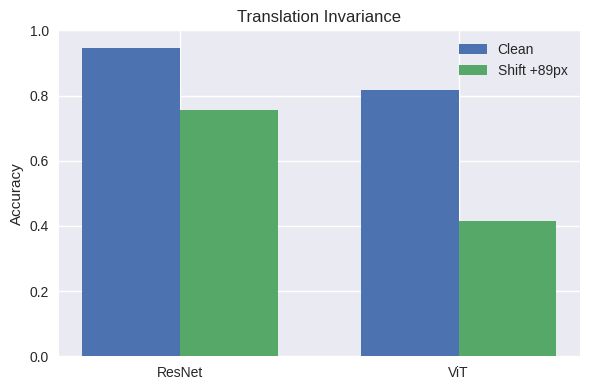

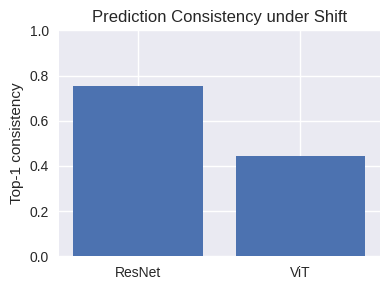

In [9]:
from torchvision.transforms import functional as TF

class TranslateTransform:
    def __init__(self, dx, dy, img_size=224, fill=0):
        self.dx, self.dy, self.img_size, self.fill = dx, dy, img_size, fill
    def __call__(self, img):
        img = TF.resize(img, [self.img_size, self.img_size])
        pad_l = max(self.dx, 0); pad_r = max(-self.dx, 0)
        pad_t = max(self.dy, 0); pad_b = max(-self.dy, 0)
        img = TF.pad(img, [pad_l, pad_t, pad_r, pad_b], fill=self.fill)
        img = TF.crop(img, pad_b, pad_r, self.img_size, self.img_size)
        t = TF.to_tensor(img); t = TF.normalize(t, [0.5]*3, [0.5]*3)
        return t

IMG_SIZE = 224
SHIFT = int(0.40 * IMG_SIZE)  # 40% of the image (~90 px)

shift_test = datasets.STL10(root='./data', split='test', download=True,
                            transform=TranslateTransform(+SHIFT, +SHIFT, IMG_SIZE, fill=0))
shiftloader = DataLoader(shift_test, batch_size=64, shuffle=False, num_workers=2)


@torch.no_grad()
def top1_consistency(model, loader_a, loader_b):
    model.eval(); same=total=0
    for (xa,_), (xb,_) in zip(loader_a, loader_b):
        pa = model(xa.to(device)).argmax(1).cpu()
        pb = model(xb.to(device)).argmax(1).cpu()
        same += (pa==pb).sum().item(); total += pa.numel()
    return same/max(total,1)

cons_res = top1_consistency(resnet, testloader, shiftloader)
cons_vit = top1_consistency(vit,    testloader, shiftloader)
acc_res_s = evaluate(resnet, shiftloader); acc_vit_s = evaluate(vit, shiftloader)

print(f"Consistency (+{SHIFT}px) — ResNet: {cons_res:.3f} | ViT: {cons_vit:.3f}")
print(f"Shifted acc — ResNet: {acc_res_s:.3f} (Δ{acc_res_s-resnet_clean:+.3f}) | "
      f"ViT: {acc_vit_s:.3f} (Δ{acc_vit_s-vit_clean:+.3f})")

# Bars
x = np.arange(2); w=0.35
plt.figure(figsize=(6,4))
plt.bar(x-w/2, [resnet_clean, vit_clean], width=w, label="Clean")
plt.bar(x+w/2, [acc_res_s,   acc_vit_s], width=w, label=f"Shift +{SHIFT}px")
plt.xticks(x, ["ResNet","ViT"]); plt.ylim(0,1); plt.ylabel("Accuracy")
plt.title("Translation Invariance"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(4,3))
plt.bar(["ResNet","ViT"], [cons_res, cons_vit])
plt.ylim(0,1); plt.ylabel("Top-1 consistency"); plt.title("Prediction Consistency under Shift")
plt.tight_layout(); plt.show()

**Permutation / Occlusion Test**

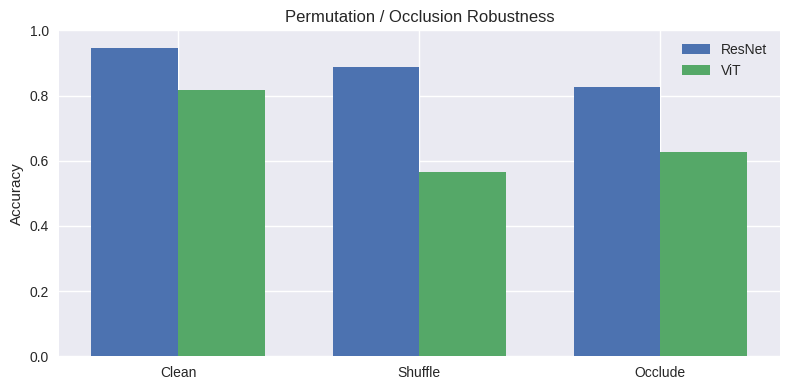

Occlusion maps — ResNet


/tmp/ipython-input-1405664208.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


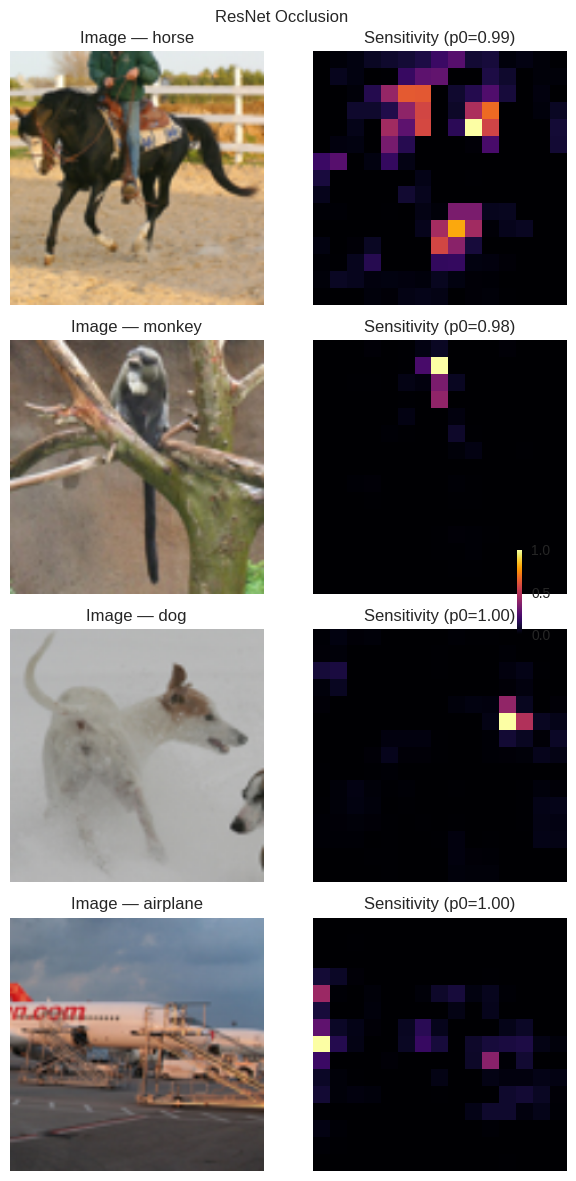

Occlusion maps — ViT


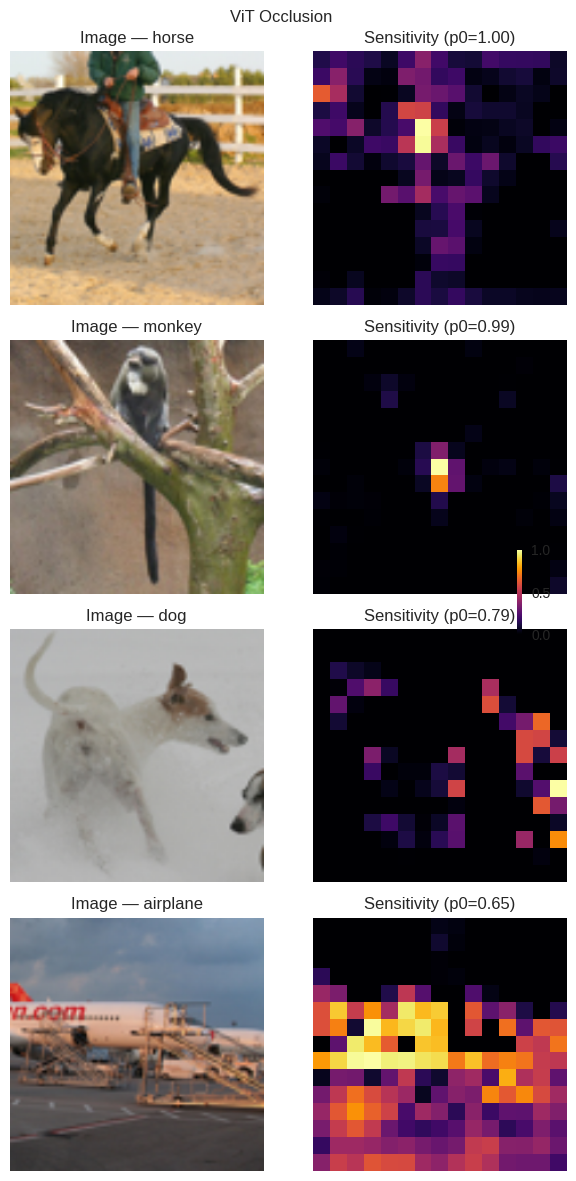

Occlusion maps — ResNet (Occluded)


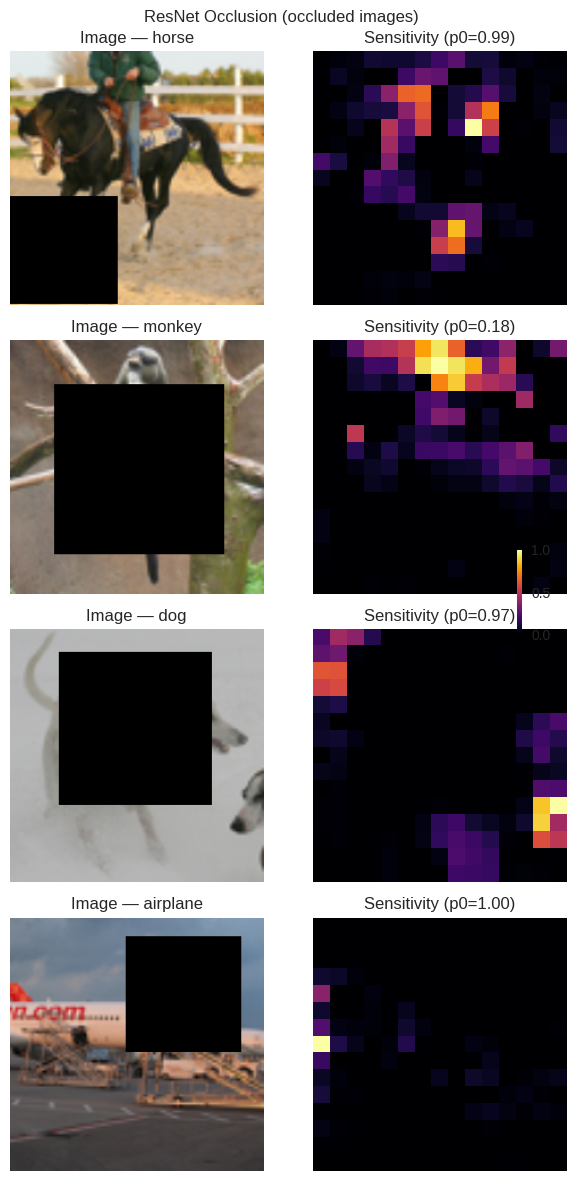

Occlusion maps — ViT (Occluded)


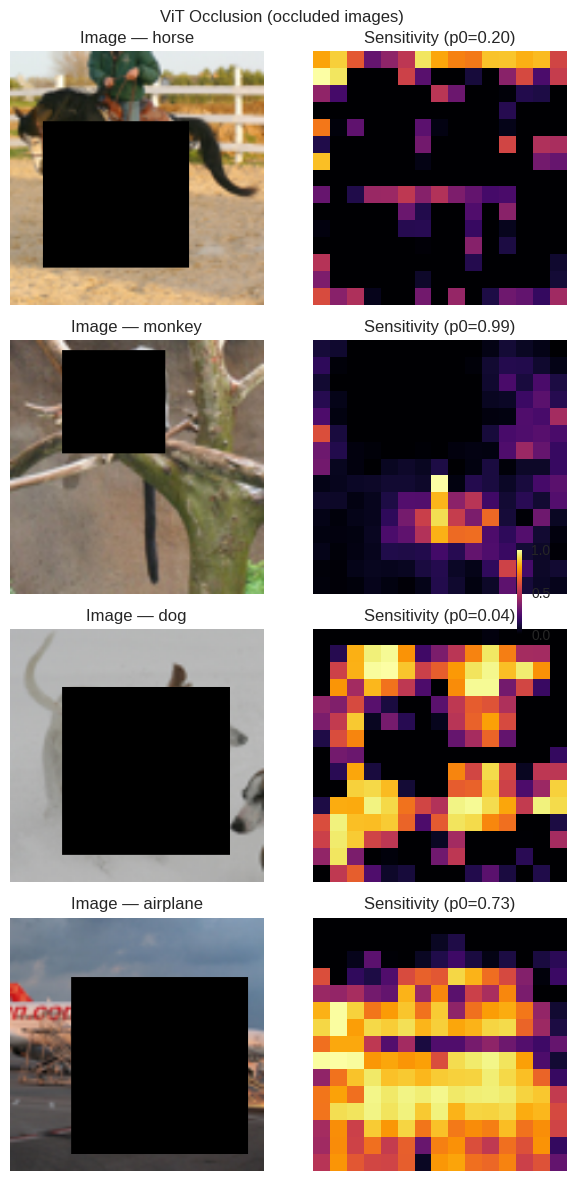

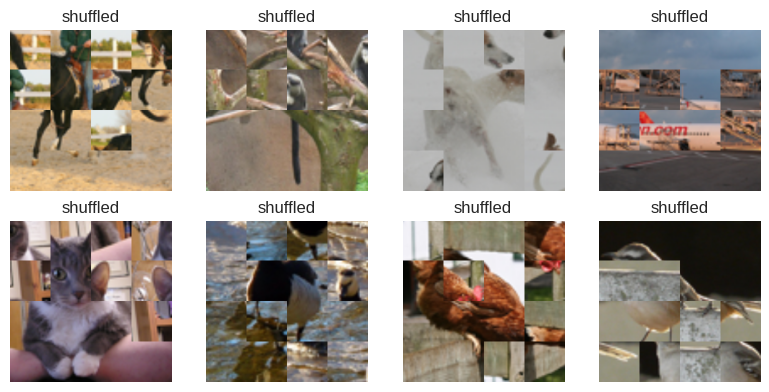

In [15]:
import random
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader

# PatchShuffle: saliency-guided
class PatchShuffle:
    """
    Saliency-guided patch permutation.
    - Splits image into a GxG grid.
    - Scores each patch using Sobel gradient magnitude (grayscale).
    - Shuffles only the top 'top_frac' patches among themselves; leaves others in place.
    """
    def __init__(self, img_size=224, grid=4, top_frac=0.5, deterministic=False):
        self.img_size, self.grid = img_size, grid
        self.top_frac = float(top_frac)
        self.deterministic = deterministic
        # Sobel kernels for saliency scoring
        kx = torch.tensor([[1, 0, -1],
                           [2, 0, -2],
                           [1, 0, -1]], dtype=torch.float32).view(1,1,3,3)
        ky = torch.tensor([[1,  2,  1],
                           [0,  0,  0],
                           [-1, -2, -1]], dtype=torch.float32).view(1,1,3,3)
        self.kx, self.ky = kx, ky

    def _score_saliency(self, t):
        # Grayscale mean across channels
        gray = t.mean(0, keepdim=True).unsqueeze(0)  # 1x1xHxW
        gx = F.conv2d(gray, self.kx.to(t.device), padding=1)
        gy = F.conv2d(gray, self.ky.to(t.device), padding=1)
        mag = (gx**2 + gy**2).sqrt().squeeze()  # HxW
        C,H,W = t.shape; g = self.grid
        ph, pw = H // g, W // g
        scores = []
        for gy_idx in range(g):
            for gx_idx in range(g):
                y0, y1 = gy_idx*ph, (gy_idx+1)*ph
                x0, x1 = gx_idx*pw, (gx_idx+1)*pw
                scores.append(mag[y0:y1, x0:x1].mean())
        return torch.stack(scores)

    def __call__(self, img):
        rnd = random.Random(12345) if self.deterministic else random
        img = TF.resize(img, [self.img_size, self.img_size])
        t = TF.to_tensor(img)
        C,H,W = t.shape; g = self.grid; ph, pw = H//g, W//g
        patches = [t[:, gy*ph:(gy+1)*ph, gx*pw:(gx+1)*pw] for gy in range(g) for gx in range(g)]

        scores = self._score_saliency(t)
        K = max(1, int(round(self.top_frac * (g * g))))
        top_idx = torch.topk(scores, k=K, largest=True).indices.tolist()
        top_idx_shuffled = top_idx[:]; rnd.shuffle(top_idx_shuffled)

        new_patches = patches[:]
        for src, dst in zip(top_idx, top_idx_shuffled):
            new_patches[dst] = patches[src]

        rows = [torch.cat(new_patches[i*g:(i+1)*g], dim=2) for i in range(g)]
        out = torch.cat(rows, dim=1)
        return TF.normalize(out, [0.5]*3, [0.5]*3)

# PatchOcclude: variable-size occlusion
class PatchOcclude:
    def __init__(self, img_size=224, min_frac=0.3, max_frac=0.7):
        self.img_size = img_size
        self.min_frac = min_frac
        self.max_frac = max_frac
    def __call__(self, img):
        img = TF.resize(img, [self.img_size, self.img_size])
        t = TF.to_tensor(img)
        # Randomly pick box size as a fraction of image size
        frac = random.uniform(self.min_frac, self.max_frac)
        box = int(frac * self.img_size)
        y = random.randint(0, self.img_size - box)
        x = random.randint(0, self.img_size - box)
        t[:, y:y+box, x:x+box] = 0.0
        return TF.normalize(t, [0.5]*3, [0.5]*3)

# Dataset setup
shuffle_test  = datasets.STL10('./data', split='test', download=True,
                               transform=PatchShuffle(224, grid=4))
occ_test      = datasets.STL10('./data', split='test', download=True,
                               transform=PatchOcclude(224, min_frac=0.4, max_frac=0.7))
shuffleloader = DataLoader(shuffle_test, batch_size=64, shuffle=False, num_workers=2)
occloader     = DataLoader(occ_test,     batch_size=64, shuffle=False, num_workers=2)

# Evaluation
res_shuffle = evaluate(resnet, shuffleloader); vit_shuffle = evaluate(vit, shuffleloader)
res_occ     = evaluate(resnet, occloader);     vit_occ     = evaluate(vit, occloader)

labels = ["Clean","Shuffle","Occlude"]
res_vals = [resnet_clean, res_shuffle, res_occ]
vit_vals = [vit_clean,    vit_shuffle, vit_occ]

x = np.arange(len(labels)); w=0.36
plt.figure(figsize=(8,4))
plt.bar(x-w/2, res_vals, width=w, label="ResNet")
plt.bar(x+w/2, vit_vals, width=w, label="ViT")
plt.xticks(x, labels); plt.ylim(0,1); plt.ylabel("Accuracy")
plt.title("Permutation / Occlusion Robustness"); plt.legend(); plt.tight_layout(); plt.show()

# Occlusion sensitivity heat-maps
def occlusion_map(model, img, true_idx=None, patch=28, stride=14):
    model.eval(); H,W = img.shape[1:]
    with torch.no_grad():
        base = model(img.unsqueeze(0).to(device)).softmax(1).cpu()[0]
    if true_idx is None: true_idx = int(base.argmax().item())
    base_p = float(base[true_idx])
    hh = (H - patch)//stride + 1; ww = (W - patch)//stride + 1
    heat = np.zeros((hh, ww), dtype=np.float32)
    with torch.no_grad():
        for i in range(hh):
            for j in range(ww):
                occl = img.clone()
                y0, x0 = i*stride, j*stride
                occl[:, y0:y0+patch, x0:x0+patch] = 0.0
                p = model(occl.unsqueeze(0).to(device)).softmax(1).cpu()[0, true_idx].item()
                heat[i,j] = max(0.0, base_p - p)
    heat /= (heat.max()+1e-8)
    return heat, true_idx, base_p

def show_occlusion(model, loader, title, n=4):
    imgs, labs = next(iter(loader)); imgs, labs = imgs[:n], labs[:n]
    fig, axes = plt.subplots(n, 2, figsize=(6, 3*n))
    for i in range(n):
        heat, t_idx, p0 = occlusion_map(model, imgs[i], int(labs[i]), patch=28, stride=14)
        axes[i,0].imshow(np.transpose(((imgs[i]*0.5+0.5).numpy()), (1,2,0)))
        axes[i,0].set_title(f"Image — {class_names[int(labs[i])]}"); axes[i,0].axis('off')
        im = axes[i,1].imshow(heat, cmap='inferno', vmin=0, vmax=1)
        axes[i,1].set_title(f"Sensitivity (p0={p0:.2f})"); axes[i,1].axis('off')
    fig.suptitle(title); fig.colorbar(im, ax=axes[:,1], fraction=0.02)
    plt.tight_layout(); plt.show()

print("Occlusion maps — ResNet"); show_occlusion(resnet, testloader, "ResNet Occlusion", n=4)
print("Occlusion maps — ViT");   show_occlusion(vit,    testloader, "ViT Occlusion",   n=4)

print("Occlusion maps — ResNet (Occluded)")
show_occlusion(resnet, occloader, "ResNet Occlusion (occluded images)", n=4)

print("Occlusion maps — ViT (Occluded)")
show_occlusion(vit,    occloader, "ViT Occlusion (occluded images)",   n=4)

# Show shuffled images
imgs, labs = next(iter(shuffleloader))
plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(np.transpose((imgs[i]*0.5+0.5).numpy(), (1,2,0)))
    plt.axis('off'); plt.title("shuffled")
plt.tight_layout(); plt.show()

**Feature Representation Analysis**

Embedding plots…


/tmp/ipython-input-1182562978.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


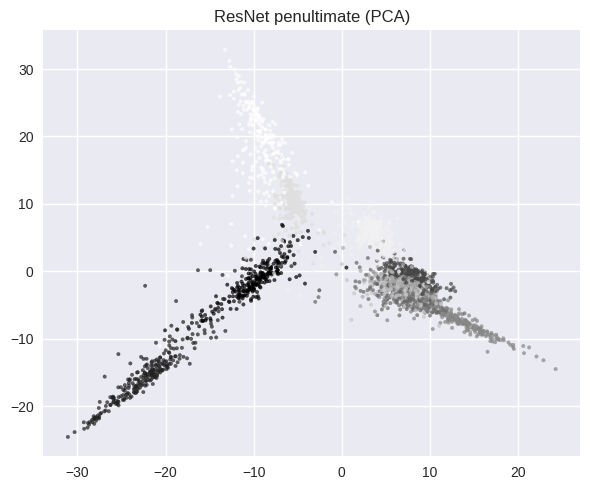

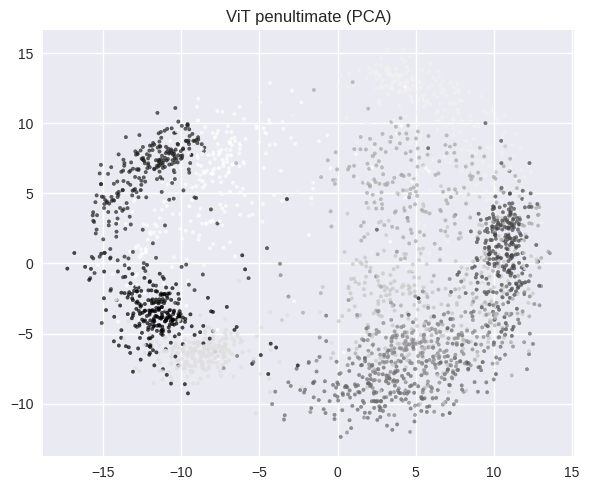

In [12]:
# Extract penultimate embeddings and plot 2-D (PCA/SVD)
def extract_embeddings(model, loader, max_batches=40):
    feats, labels = [], []
    # Choose hook point
    if isinstance(model, torchvision.models.ResNet):
        hook_module = model.avgpool
        def proc(o): return o.flatten(1)
    else:
        hook_module = getattr(getattr(model, "encoder", None), "ln", None) or model.heads
        def proc(o):
            if o.ndim == 3:  # (N, tokens, dim) -> CLS
                return o[:,0,:]
            return o.flatten(1) if o.ndim>2 else o
    def hook(_, __, out): feats.append(proc(out).detach().cpu())
    h = hook_module.register_forward_hook(hook)
    with torch.no_grad():
        for i,(x,y) in enumerate(loader):
            _ = model(x.to(device))
            labels.append(y)
            if i+1 >= max_batches: break
    h.remove()
    return torch.cat(feats,0).numpy(), torch.cat(labels,0).numpy()

def pca2(X):
    Xc = X - X.mean(axis=0, keepdims=True)
    U,S,Vt = np.linalg.svd(Xc, full_matrices=False)
    return Xc @ Vt[:2].T

def scatter2d(Z, y, title):
    plt.figure(figsize=(6,5))
    plt.scatter(Z[:,0], Z[:,1], c=y, s=6, alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("Embedding plots…")
fe_r, lb_r = extract_embeddings(resnet, testloader, max_batches=40)
fe_v, lb_v = extract_embeddings(vit,    testloader, max_batches=40)
scatter2d(pca2(fe_r), lb_r, "ResNet penultimate (PCA)")
scatter2d(pca2(fe_v), lb_v, "ViT penultimate (PCA)")

Embedding plots… (t-SNE)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


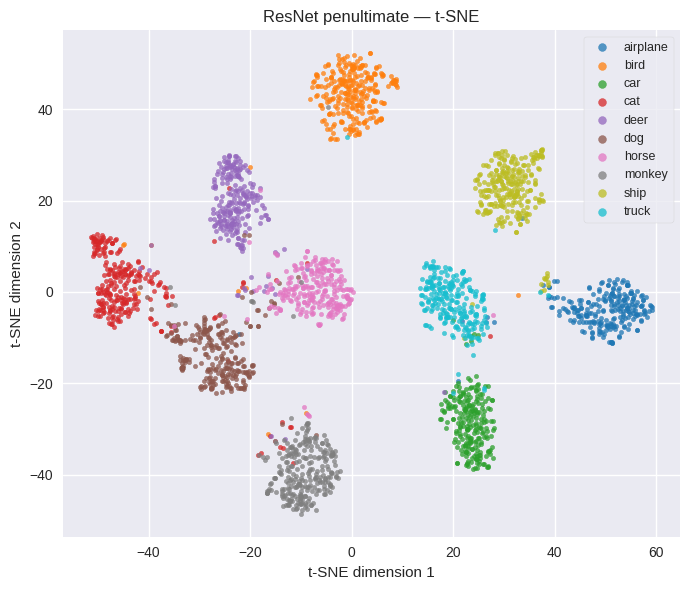

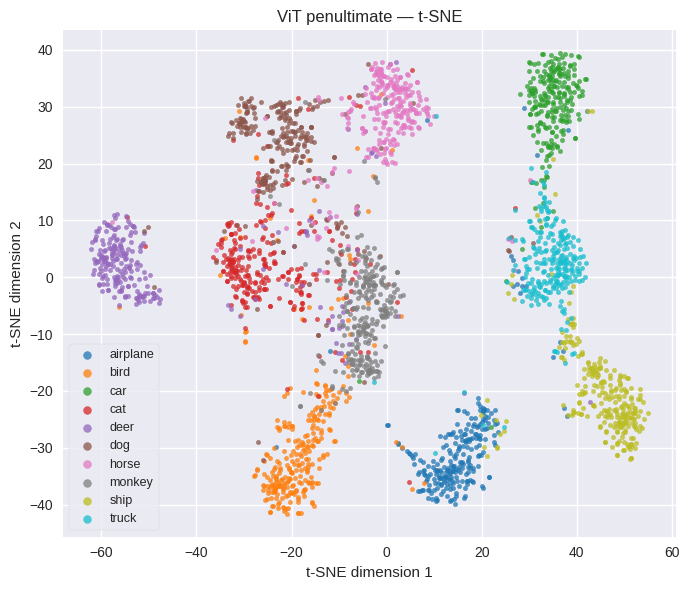

In [16]:
# Extract penultimate embeddings and plot 2-D (t-SNE)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch

def extract_embeddings(model, loader, max_batches=40):
    feats, labels = [], []
    # Choose hook point
    if isinstance(model, torchvision.models.ResNet):
        hook_module = model.avgpool
        def proc(o): return o.flatten(1)
    else:
        hook_module = getattr(getattr(model, "encoder", None), "ln", None) or model.heads
        def proc(o):
            if o.ndim == 3:  # (N, tokens, dim) -> CLS
                return o[:,0,:]
            return o.flatten(1) if o.ndim>2 else o
    def hook(_, __, out): feats.append(proc(out).detach().cpu())
    h = hook_module.register_forward_hook(hook)
    with torch.no_grad():
        for i,(x,y) in enumerate(loader):
            _ = model(x.to(device))
            labels.append(y)
            if i+1 >= max_batches: break
    h.remove()
    return torch.cat(feats,0).numpy(), torch.cat(labels,0).numpy()

def tsne2(X, perplexity=30, n_iter=1000, random_state=42):
    # t-SNE on standardized features tends to behave better
    X = X - X.mean(0, keepdims=True)
    X = X / (X.std(0, keepdims=True) + 1e-8)
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter,
                init="pca", learning_rate="auto", random_state=random_state)
    return tsne.fit_transform(X)

def scatter2d_tsne(Z, y, title, class_names=None):
    plt.figure(figsize=(7,6))
    y = np.asarray(y)
    classes = np.unique(y)
    # choose a colormap that has enough distinct colors
    cmap = plt.get_cmap("tab20" if len(classes) > 10 else "tab10")
    for i, cls in enumerate(classes):
        idx = y == cls
        label = (class_names[int(cls)] if (class_names is not None and int(cls) < len(class_names))
                 else str(int(cls)))
        plt.scatter(Z[idx,0], Z[idx,1], s=10, alpha=0.75, label=label, c=[cmap(i)])
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")
    plt.title(title)
    plt.legend(markerscale=1.8, fontsize=9, frameon=True, loc="best")
    plt.tight_layout()
    plt.show()

print("Embedding plots… (t-SNE)")
fe_r, lb_r = extract_embeddings(resnet, testloader, max_batches=40)
fe_v, lb_v = extract_embeddings(vit,    testloader, max_batches=40)

Zr = tsne2(fe_r, perplexity=30, n_iter=1000, random_state=42)
Zv = tsne2(fe_v, perplexity=30, n_iter=1000, random_state=42)

# uses your existing `class_names` if defined; else falls back to numeric labels
try:
    _ = class_names
except NameError:
    class_names = None

scatter2d_tsne(Zr, lb_r, "ResNet penultimate — t-SNE", class_names)
scatter2d_tsne(Zv, lb_v, "ViT penultimate — t-SNE",   class_names)

**Domain Generalization Test on PACS**

No local PACS found under ./PACS. Falling back to Hugging Face dataset.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Using HUGGINGFACE PACS | train domains: ['photo', 'art_painting', 'cartoon'] | test: sketch | #classes=7
Train domain counts: {'art_painting': 2048, 'cartoon': 2344, 'photo': 1670}
Test  domain counts: {'sketch': 3929}
Training ResNet on PACS...
Epoch 1: train_acc=0.889, val_acc=0.739
Epoch 2: train_acc=0.979, val_acc=0.703

Training ViT on PACS...
Epoch 1: train_acc=0.834, val_acc=0.584
Epoch 2: train_acc=0.932, val_acc=0.579

PACS held-out (sketch) — ResNet: 0.703 | ViT: 0.579


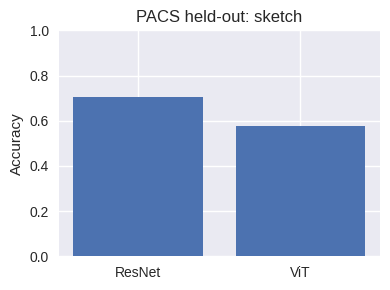

In [13]:
# Domain Generalization Test on PACS (local-or-HuggingFace fallback)

RUN_PACS    = True
PACS_ROOT   = "./PACS"    # Parent path to search inside for the 4 domain folders
PACS_TEST   = "sketch"    # 'photo' | 'art_painting' | 'cartoon' | 'sketch'
PACS_EPOCHS = 2           # Small for demo

import os, glob
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import ConcatDataset, DataLoader, Dataset
from torchvision import datasets, transforms, models

DOMAINS = ['photo', 'art_painting', 'cartoon', 'sketch']

def _has_domain_dirs(path):
    try:
        names = {e.name for e in os.scandir(path) if e.is_dir()}
    except FileNotFoundError:
        return False
    return set(DOMAINS).issubset(names)

def find_pacs_root(base):
    base = os.path.abspath(os.path.expanduser(base))
    candidates = [
        base,
        os.path.join(base, "PACS"),
        os.path.join(base, "kfold"),
        os.path.join(base, "images"),
        os.path.join(base, "split_images"),
    ]
    for c in candidates:
        if _has_domain_dirs(c):
            return c
    # Bounded recursive search
    for root, dirs, files in os.walk(base):
        depth = root[len(base):].count(os.sep)
        if depth > 3:
            continue
        if _has_domain_dirs(root):
            return root
    return None

def run_local_pacs(pacs_root, test_domain, epochs):
    tfm = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    ])
    train_sets = []
    for d in DOMAINS:
        if d == test_domain:
            continue
        ds = datasets.ImageFolder(os.path.join(pacs_root, d), transform=tfm)
        if len(ds) == 0:
            raise RuntimeError(f"Domain '{d}' is empty at {os.path.join(pacs_root, d)}")
        train_sets.append(ds)
    pacs_train = ConcatDataset(train_sets)
    pacs_test  = datasets.ImageFolder(os.path.join(pacs_root, test_domain), transform=tfm)
    if len(pacs_test) == 0:
        raise RuntimeError(f"Held-out domain '{test_domain}' is empty at {os.path.join(pacs_root, test_domain)}")

    tl = DataLoader(pacs_train, batch_size=64, shuffle=True,  num_workers=2)
    pl = DataLoader(pacs_test,  batch_size=64, shuffle=False, num_workers=2)
    ncls = len(pacs_test.classes)
    print(f"Using LOCAL PACS at {pacs_root} | train domains: {[d for d in DOMAINS if d!=test_domain]} | test: {test_domain} | #classes={ncls}")
    return tl, pl, ncls

class HFPACSDataset(Dataset):
    """Wrap a HF split filtered by domain -> returns (tensor_image, label) using a torchvision transform."""
    def __init__(self, hf_ds, transform):
        self.ds = hf_ds
        self.transform = transform
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = ex["image"]    # PIL Image
        y   = int(ex["label"])
        x   = self.transform(img)
        return x, y

def run_hf_pacs(test_domain, epochs):
    # Install datasets if missing
    try:
        import datasets as hfds
    except ImportError:
        import sys
        !{sys.executable} -m pip -q install datasets
        import datasets as hfds

    ds_all = hfds.load_dataset("flwrlabs/pacs")["train"]  # Fields: image (PIL), domain (str), label (int)
    domains = list(set(ds_all["domain"]))
    if test_domain not in domains:
        raise RuntimeError(f"Requested PACS_TEST='{test_domain}' not found in HF dataset domains: {sorted(domains)}")

    tfm = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    ])

    # Split into train (3 domains) and test (held-out domain)
    ds_train_hf = ds_all.filter(lambda e: e["domain"] != test_domain)
    ds_test_hf  = ds_all.filter(lambda e: e["domain"] == test_domain)

    train_ds = HFPACSDataset(ds_train_hf, tfm)
    test_ds  = HFPACSDataset(ds_test_hf,  tfm)

    tl = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=2)
    pl = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2)

    ncls = len(set(ds_all["label"]))
    print(f"Using HUGGINGFACE PACS | train domains: {[d for d in DOMAINS if d!=test_domain]} | test: {test_domain} | #classes={ncls}")
    # Quick counts
    def count_by_domain(hf_ds):
        from collections import Counter
        return Counter(hf_ds["domain"])
    print("Train domain counts:", dict(count_by_domain(ds_train_hf)))
    print("Test  domain counts:", dict(count_by_domain(ds_test_hf)))
    return tl, pl, ncls

if not RUN_PACS:
    print("RUN_PACS is False. Set RUN_PACS=True to enable the PACS experiment.")
else:
    pacs_root = find_pacs_root(PACS_ROOT)
    try:
        if pacs_root is not None:
            pacs_train, pacs_test_loader, ncls = run_local_pacs(pacs_root, PACS_TEST, PACS_EPOCHS)
        else:
            print(f"No local PACS found under {PACS_ROOT}. Falling back to Hugging Face dataset.")
            pacs_train, pacs_test_loader, ncls = run_hf_pacs(PACS_TEST, PACS_EPOCHS)

        # Fresh heads for PACS classes
        res_p = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        res_p.fc = nn.Linear(res_p.fc.in_features, ncls); res_p = res_p.to(device)

        vit_p = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
        if hasattr(vit_p.heads, "head"):
            vit_p.heads.head = nn.Linear(vit_p.heads.head.in_features, ncls)
        else:
            vit_p.heads = nn.Linear(vit_p.heads.in_features, ncls)
        vit_p = vit_p.to(device)

        print("Training ResNet on PACS...")
        train_model(res_p, pacs_train, pacs_test_loader, epochs=PACS_EPOCHS)

        print("\nTraining ViT on PACS...")
        train_model(vit_p, pacs_train, pacs_test_loader, epochs=PACS_EPOCHS)

        acc_r = evaluate(res_p, pacs_test_loader)
        acc_v = evaluate(vit_p, pacs_test_loader)
        print(f"\nPACS held-out ({PACS_TEST}) — ResNet: {acc_r:.3f} | ViT: {acc_v:.3f}")

        # Bar chart
        plt.figure(figsize=(4,3))
        plt.bar(["ResNet","ViT"], [acc_r, acc_v])
        plt.ylim(0,1); plt.ylabel("Accuracy"); plt.title(f"PACS held-out: {PACS_TEST}")
        plt.tight_layout(); plt.show()

    except Exception as e:
        print("PACS experiment failed with the following error:")
        print(repr(e))
        print("\nTo run locally, arrange your data as:\n"
              "  <root>/photo/<class>/*.jpg\n"
              "  <root>/art_painting/<class>/*.jpg\n"
              "  <root>/cartoon/<class>/*.jpg\n"
              "  <root>/sketch/<class>/*.jpg\n"
              "and set PACS_ROOT to <root>.")
